# Gaussian Processes and Gaussian Process Regression

This notebook will walk through the key mathematical details required to understand what a Gaussian Process is and how Gaussian Process Regression works.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(15)

Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a Gaussian Process is fully specified by a mean function and a covariance function

$$p(x) \sim \mathcal{GP}(m(x), k(x,x'))$$

For example, take the mean function equal to 0 and the squared exponential covariance function

$$m(x) = 0$$
$$k(x,x') = \theta_1 \cdot exp \left(- \frac{\theta_2}{2}(x - x')^2 \right)$$

It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function. It is common to take a mean function of 0 as the prior and rely completely on the covariance function for learning.

Let's walk through a Gaussian Process Regression example using the prior GP we just defined above. First we define the mean and covariance functions. We will start with hyperpareters $\sigma_0 = 1$, $\sigma_1=10$.

In [2]:
xpts = np.linspace(-3, 3, 1000)

mean_prior = [0 for x in xpts]

def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x, y)**2)


theta = [1, 10]

sigma_0 = [exponential_cov(xpt, xpt, theta) for xpt in xpts]

Based on the prior and hyperparameters we chose, the mean at every point in our domain is 0 and the standard deviatoin at every point in our domain is 1. It is important to remember that each value on the $x$ axis has a corresponding normal distribution. That is, the value $x = 1$ has a normal distribution represented by $y$ values along the $y$ axis. So does $x = \pi$, $x = e$, and $x = -1.23$, etc. This GP represents uncountbaly infinite normal distributions. That being said, we only need to store in the computer those of which we want to compute.

Below we plot our GP prior.

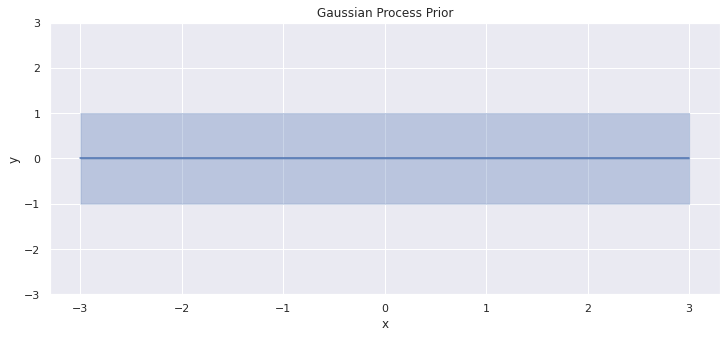

In [4]:
sns.set(rc = {'figure.figsize':(12,5)})

plt.plot(xpts, mean_prior, label="mean");
stdev_plus = [x + sigma for x, sigma in zip(mean_prior, sigma_0)]
stdev_minus = [x - sigma for x, sigma in zip(mean_prior, sigma_0)]
plt.fill_between(xpts, stdev_plus, color="b", alpha=0.3);
plt.fill_between(xpts, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Prior");

We have our first Gaussian Process! Lets take a sample at x = 1, to make our first observation. The default values for np.random.normal() are a mean of 0 and a standard deviation of 1, so that will work as our first sample.

In [5]:
x = [1.]
y = [np.random.normal()]
print(f"x: {x}")
print(f"y: {y}")

# New sigma
sigma_1 = exponential_cov(x, x, theta)
print(f"sigma_1: {sigma_1}")

x: [1.0]
y: [-0.3123284815435444]
sigma_1: [[1.]]


Now we have our first observation, $(1, -0.312)$. From here, we will need to use some conditioning formulas for multivariate Gaussian Distributions so we can condition our Gaussian Process prior on this observation and obtain our Posterior. The conditioning property of multivariate Gaussian Distributions gives us the following mean and covariance fucntions for $p(x|y = a)$

$$\mu = \mu_x + \Sigma_{xy} \Sigma_y^{-1}(a - \mu_y)$$
$$\sigma = \Sigma_x - \Sigma_{xy} \Sigma_y^{-1} \Sigma_{yx}$$

Our first oberservation is $(1, -0.312)$. We need to compute the resulting normal distribution at all the remaining points in xpts. To help us understand how that calculation works, let us start with a single unkown point from xpts, say $x=0.7$. We want to know the probability distribution for $y$ at $x=0.7$ given the data we know, by using the formulas above. Let's take $x_0 = 1$ and $x_1 = 0.7$.

Remember! Here $x_1$ represents a normal distribution. Moreover, $x_0$ has been observed and no longer represents a normal distribution, we take the value of $-0.312$ for $x_0$.

$p(x_1 \; | \; x_0 = -0.312)$

$\mu = \mu_{x_1} + \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} (-0.312 - \mu_{x_0})$

$\sigma = \Sigma_{x_1} - \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} \Sigma_{x_0 x_1}$

Let's calculate this!

Reference: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

In [6]:
x_1 = 0.7

# covariance matrix for known data
Sigma_x = np.array([exponential_cov(x, x, theta)])

# covariance matrix for new data
Sigma_x1 = np.array([exponential_cov(x_1, x_1, theta)])

# covariance matricies for known and new data
Sigma_x1_x = np.array([exponential_cov(x_1, x, theta)])
Sigma_x_x1 = np.array([exponential_cov(x, x_1, theta)])

# inverse of Sigma_x_0
Sigma_x_inv = np.linalg.inv(Sigma_x)

mu = 0 + np.dot(Sigma_x1_x, Sigma_x_inv).dot(y)
sigma = Sigma_x1 - np.dot(Sigma_x1_x, Sigma_x_inv).dot(Sigma_x_x1)

print(mu.squeeze(), sigma.squeeze())

-0.19914943238544533 0.593430340259401


Turn this into a function.

In [7]:
def conditional(x_new, x, y, params):
    Sigma_x_new_x = exponential_cov(x_new, x, params)
    Sigma_x_x_new = exponential_cov(x, x_new, params)
    Sigma_x_x = exponential_cov(x, x, params)
    Sigma_x_new_x_new = exponential_cov(x_new, x_new, params)

    Sigma_x_inv = np.linalg.inv(Sigma_x_x)

    mu = 0 + np.dot(Sigma_x_new_x, Sigma_x_inv).dot(y)
    sigma = Sigma_x_new_x_new - np.dot(Sigma_x_new_x, Sigma_x_inv).dot(Sigma_x_x_new)
    return(mu.squeeze(), sigma.squeeze())

In [8]:
conditional(0.7, x, y, theta)

(-0.19914943238544533, 0.593430340259401)

We will take a finite collection of points in our domain, then determine the normal distribution at each point given our conditional fucntion, then plot said distributions to get our posterior GP.

In [9]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [conditional(i, x, y, theta) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

Plot the results:

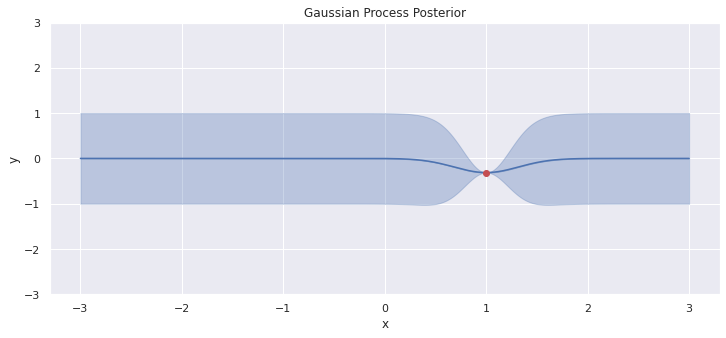

In [10]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

To help understand what has chanaged, consider how the distribution for $0.7$ has been conditioned on our known data $x$. We can pull this distrubution for $x=0.7$ by evaluating our `conditional` function at $x=0.7$ using our known data.

In [11]:
mu, sigma = conditional(0.7, x, y, theta)
print(mu, sigma)

-0.19914943238544533 0.593430340259401


Plot this distrubtion over our posterior GP

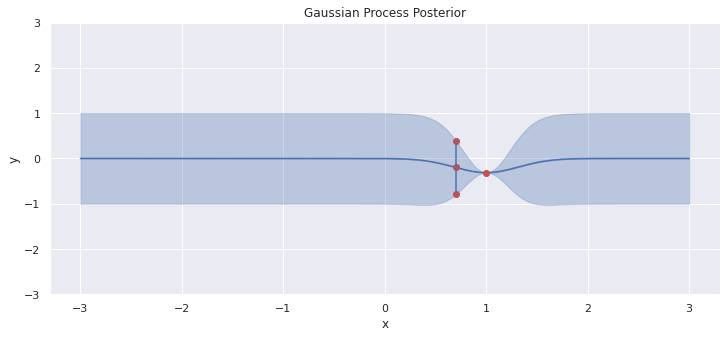

In [12]:
sns.set()
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

plt.plot(0.7, mu, "ro");
plt.plot(0.7, mu + sigma, "ro");
plt.plot(0.7, mu - sigma, "ro");
plt.vlines(x=0.7, ymin=mu-sigma, ymax=mu+sigma);

Next, take another sample, say $x = -1.5$. First, calculate the normal distribution at $x = -1.5$. Then take a sample from that distribution as our next observation.

In [13]:
x_1 = -1.5
# Get the normal distribution at -1.5
mu, sigma = conditional(x_1, x, y, theta)
print(mu, sigma)

-8.373538670366601e-15 1.0


In [14]:
# Sample the distribution to make our next observation
y_1 = np.random.normal(mu, sigma)
print(y_1)

# Append the new data
x.append(x_1)
y.append(y_1)

0.339284706046176


Calculate the resulting posterior GP and plot.

In [15]:
predictions = [conditional(i, x, y, theta) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

We get the following Posterior Gaussian Process

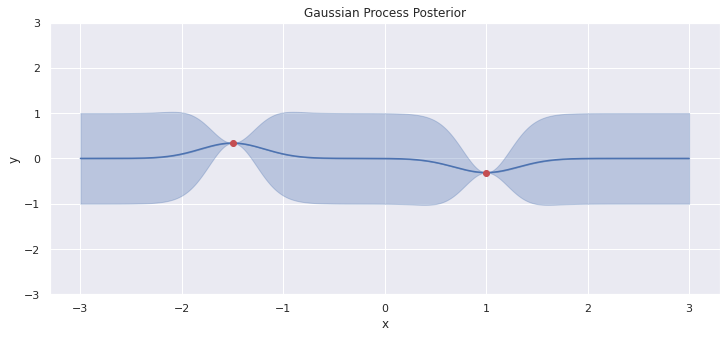

In [16]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

We can make multiple observations at once and upadate our GP. First, decide where to make observations using `x_observations` then use our `conditional` function to determine the corresponding mean vector and covariance matrix, which represent a multivariate normal distribution.

In [17]:
x_observations = [-2.1, -0.5, 0.3, 1.8, 2.5]

mu, s = conditional(x_observations, x, y, theta)
print("Mean Vector:")
print(mu)
print("Covariance Matrix:")
print(s)

Mean Vector:
[ 5.60833847e-02  2.28201982e-03 -2.69519136e-02 -1.27311973e-02
 -4.06254953e-06]
Covariance Matrix:
[[ 9.72676278e-01 -1.11101438e-03 -1.52296687e-08  1.80644564e-16
   5.76440278e-20]
 [-1.11101438e-03  9.99954600e-01  4.07610809e-02 -5.30202862e-07
  -1.69189792e-10]
 [-1.52296687e-08  4.07610809e-02  9.92553417e-01 -3.50450948e-03
  -1.12241546e-06]
 [ 1.80644564e-16 -5.30202862e-07 -3.50450948e-03  9.98338443e-01
   8.62930563e-02]
 [ 5.76440278e-20 -1.69189792e-10 -1.12241546e-06  8.62930563e-02
   1.00000000e+00]]


Use the mean vector and covariance matrix to sample the multivariate normal distribution.

In [18]:
y_sample = np.random.multivariate_normal(mu, s)

print("Observations:")
print(list(zip(x_observations, y_sample.tolist())))

Observations:
[(-2.1, -0.2573237477945744), (-0.5, -0.8000577824161643), (0.3, 1.6143590482378094), (1.8, 0.8168000844207696), (2.5, -0.53394538307872)]


Add these observations to our GP and plot.

In [19]:
x += x_observations
y += y_sample.tolist()

predictions = [conditional(i, x, y, theta) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)

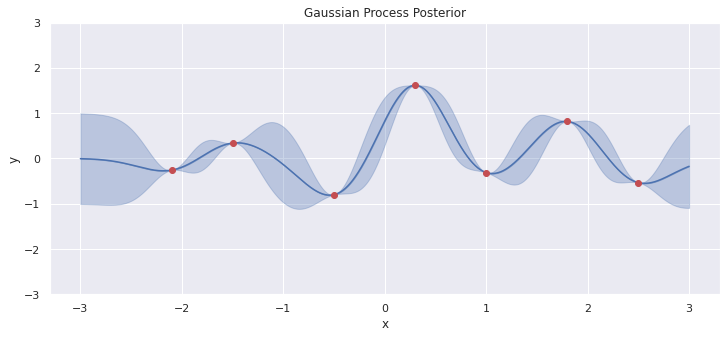

In [20]:
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

In [21]:
mu, sigma = conditional(-1, x, y, theta)
print(mu, sigma)

-0.13595829567816023 0.8347451445332503


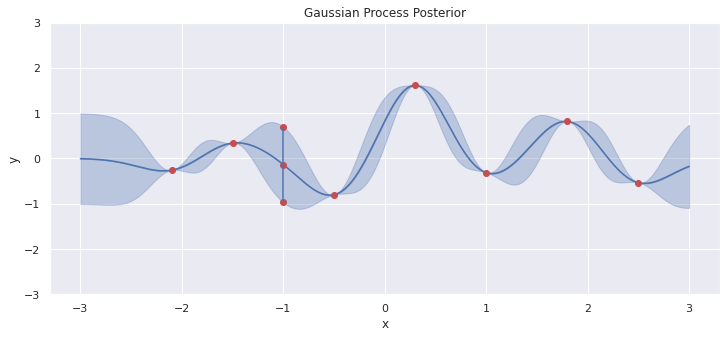

In [22]:
sns.set()
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

plt.plot(-1, mu, "ro");
plt.plot(-1, mu + sigma, "ro");
plt.plot(-1, mu - sigma, "ro");
plt.vlines(x=-1, ymin=mu-sigma, ymax=mu+sigma);

In [23]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF

In [65]:
X = np.array(x).reshape(-1, 1)
y_array = np.array(y)

gp = gaussian_process.GaussianProcessRegressor(kernel=RBF(length_scale = 0.31623))

In [62]:
gp.fit(X, y_array)

GaussianProcessRegressor(kernel=RBF(length_scale=0.316))

In [63]:
x_pred = np.linspace(-3, 3, 1000).reshape(-1, 1)
mu, sigma = gp.predict(x_pred, return_std=True)

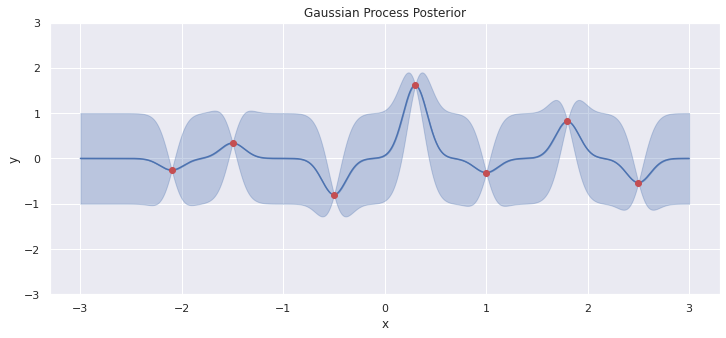

In [64]:
sns.set(rc = {'figure.figsize':(12,5)})
x_plot = np.linspace(-3, 3, 1000)
plt.plot(x_plot, mu, label="mean");
# plt.plot(x_plot, samples, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(mu, sigma)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(mu, sigma)]
plt.fill_between(x_plot, mu, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_plot, mu, stdev_minus, color="b", alpha=0.3);
plt.plot(x, y, "ro");
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");

In [ ]:
from sklearn import gaussian_process

from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel, Hyperparameter, _check_length_scale
from scipy.spatial.distance import pdist, cdist, squareform

class RBF(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def anisotropic(self):
        return np.iterable(self.length_scale) and len(self.length_scale) > 1

    @property
    def hyperparameter_length_scale(self):
        if self.anisotropic:
            return Hyperparameter(
                "length_scale",
                "numeric",
                self.length_scale_bounds,
                len(self.length_scale),
            )
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        length_scale = _check_length_scale(X, self.length_scale)
        if Y is None:
            dists = pdist(X / length_scale, metric="sqeuclidean")
            K = np.exp(-0.5 * dists)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X / length_scale, Y / length_scale, metric="sqeuclidean")
            K = np.exp(-0.5 * dists)

        if eval_gradient:
            if self.hyperparameter_length_scale.fixed:
                # Hyperparameter l kept fixed
                return K, np.empty((X.shape[0], X.shape[0], 0))
            elif not self.anisotropic or length_scale.shape[0] == 1:
                K_gradient = (K * squareform(dists))[:, :, np.newaxis]
                return K, K_gradient
            elif self.anisotropic:
                # We need to recompute the pairwise dimension-wise distances
                K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 / (
                    length_scale**2
                )
                K_gradient *= K[..., np.newaxis]
                return K, K_gradient
        else:
            return K

    def __repr__(self):
        if self.anisotropic:
            return "{0}(length_scale=[{1}])".format(
                self.__class__.__name__,
                ", ".join(map("{0:.3g}".format, self.length_scale)),
            )
        else:  # isotropic
            return "{0}(length_scale={1:.3g})".format(
                self.__class__.__name__, np.ravel(self.length_scale)[0]
            )